# SkimLit Project

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251



## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 6.02 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [2]:
# Check what files are in the PubMed_20K dataset

!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [3]:
# Start our experiments using the 20k dataset with numbers replaced by '@' sign

data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"


In [4]:
# Check all of the filenames in the target directory

import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocces data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to...

> Visualize, visualize, visualize

So with that in mind, let's write function to read in all of the lines of a target text file.



In [5]:
# Create function to read the lines of a document

def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
  filename: a string containing the target filepath.

  Returns:
  A list of strings with one string per line from the target filename.
  """
  with open (filename, "r") as f:
    return f.readlines()

In [6]:
# Let's read in the training labels

train_lines = get_lines(data_dir + "train.txt") # read the line with the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented ...

```
[{'line_number' : 0,
   'target' : 'BACKGROUND' ,
   'text' : 'There was a clinically relevant reduction in the intervention group compared to the placebo group for knee pain , physical function , PGA , and @MWD at @ weeks .\n'
   'total_lines': 11}]
   ```
   

Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling.

In [8]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [9]:
# Get data from file and preproccess it

%%time

train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")  # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples) , len(val_samples), len(test_samples)

CPU times: user 724 ms, sys: 151 ms, total: 874 ms
Wall time: 1.19 s


(180040, 30212, 30135)

In [10]:
# Check the first abstract of our training data

train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is tehe format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it?

In [11]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
# Distribution of labels in training data

train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

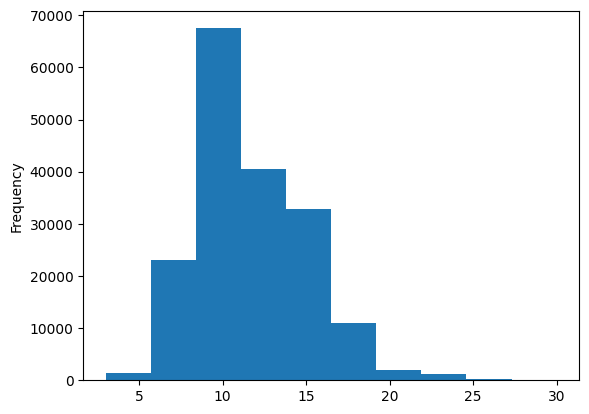

In [13]:
# Let's check the length of different lines

train_df.total_lines.plot.hist();

### Get  list of sentences

In [14]:
# Convert abstract text lines into lists

train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [15]:
# View the 10 lines of training sentences

train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numerc labels)

In [16]:
# One hot encode labels

from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False) # we want non-sparse matrix

In [17]:
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))
# Check what one hot encoded labels look like

train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [18]:
import tensorflow as tf

tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Label encode labels

In [19]:
# Extract labels ("target" columns) and encode them into integers

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

# check what training labels look like

train_labels_encoded

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


array([3, 2, 2, ..., 4, 1, 1])

In [20]:
# Get class names and number of classes from LabelEncoder instance

num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names


(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier).


## Model 0: Getting a baseline

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


# Create a pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data

model_0.fit(X = train_sentences,
            y=train_labels_encoded)



Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
# Evaluate baseline model on validation dataset

model_0.score(X=val_sentences,
              y = val_labels_encoded)

0.7218323844829869

In [23]:
# Make predictions using our baseline model

baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script



In [24]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-07-16 23:56:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-16 23:56:19 (99.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [25]:
from helper_functions import calculate_results

In [26]:
# Calculate baseline results


baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)

In [27]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


In [29]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

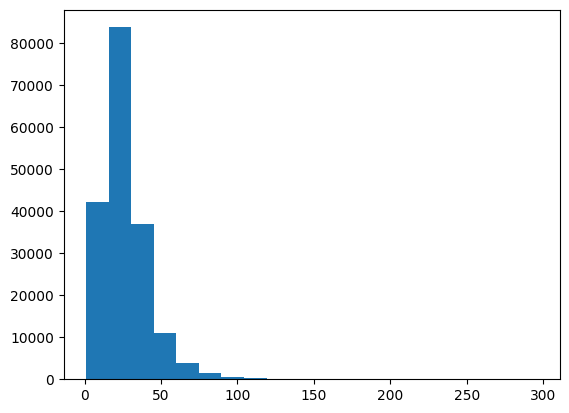

In [30]:
# What's the distribution look like ?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);


In [31]:
# How long of a sentence lenght covers 95% of examples?

output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [32]:
# Maximum sequence length in the training set

max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our text from words to numbers.

In [33]:
# How many words are in our vocab? (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [34]:
# Create text vectorizer

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens, # number of words in vocabulary
                                    output_sequence_length = output_seq_len) # desired output length of vectorized sequences



In [35]:
# Adapt text vectorizer to training sentences

text_vectorizer.adapt(train_sentences)

In [36]:
# Test out text vectorizer or random sentences

import random

target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
endoscopy and biopsy of the caudal gastrointestinal tract were performed pretreatment and on the last day of a @-day treatment period with ( @ ) oral carprofen ; ( @ ) carprofen and the proton-pump inhibitor lansoprazole ; ( @ ) carprofen , liquorice extract , and a herbal solution that contained extracts of thyme , icelandic lichen , hyssop , and saponariae root ; ( @ ) robenacoxib ; ( @ ) robenacoxib and lansoprazole ; ( @ ) robenacoxib , liquorice extract , and herbal solution ; or ( @ ) an empty gelatin capsule .

Length of text: 522

Vectorized text: [[ 2634     3  1220     4     2  5030  1027  1415     9   153  1292     3
     18     2   919   108     4     8   108    19   173     7   217 13453
  13453     3     2 11014   738  5990 13453 25924  2389     3     8  3177
    922    28  3450  6295     4 43724 18608 13909 55539     3 46280  1952
  14506 14506     3  5990 14506 25924  2389]]


In [37]:
# How many words in our training vocabulary

rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")


Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [38]:
# Get the config of our text vectorizer

text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [39]:
# Create token embedding layer

token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               mask_zero = True, # Use masking to handle variable sequence lengths (save space),
                               name="token_embedding",
                               )

In [40]:
# Show example embedding

print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 endoscopy and biopsy of the caudal gastrointestinal tract were performed pretreatment and on the last day of a @-day treatment period with ( @ ) oral carprofen ; ( @ ) carprofen and the proton-pump inhibitor lansoprazole ; ( @ ) carprofen , liquorice extract , and a herbal solution that contained extracts of thyme , icelandic lichen , hyssop , and saponariae root ; ( @ ) robenacoxib ; ( @ ) robenacoxib and lansoprazole ; ( @ ) robenacoxib , liquorice extract , and herbal solution ; or ( @ ) an empty gelatin capsule .

Sentence after vectorization (before embedding):
 [[ 2634     3  1220     4     2  5030  1027  1415     9   153  1292     3
     18     2   919   108     4     8   108    19   173     7   217 13453
  13453     3     2 11014   738  5990 13453 25924  2389     3     8  3177
    922    28  3450  6295     4 43724 18608 13909 55539     3 46280  1952
  14506 14506     3  5990 14506 25924  2389]]

Sentence after embedding:
 [[[ 0.02406548  0.027675

## Creating datasets ( making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with  the TensorFlow tf.data API, many of the steps here are discussed at lenght in these two resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [41]:
# Turn our data into TensorFlow Datasets

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [42]:
# Take the TensorSliceDataset's and turn them into prefected datasets

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [43]:
for i in train_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
       b'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
       b'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
       b'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
       b'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
       b'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - ,

## Model 1: Conv1D with token embeddings


In [44]:
# Create 1D conv model to procces sequences

inputs = layers.Input(shape = (1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output  of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile

model_1.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [45]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [46]:
# Fit the model

history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs = 3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1* len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 71s 125ms/step - loss: 0.9140 - accuracy: 0.6420 - val_loss: 0.6837 - val_accuracy: 0.7407
Epoch 2/3
562/562 [==============================] - 72s 128ms/step - loss: 0.6623 - accuracy: 0.7511 - val_loss: 0.6340 - val_accuracy: 0.7689
Epoch 3/3
562/562 [==============================] - 70s 124ms/step - loss: 0.6236 - accuracy: 0.7687 - val_loss: 0.6020 - val_accuracy: 0.7832


In [47]:
# Evaluate on whole validation dataset

model_1.evaluate(valid_dataset)

945/945 [==============================] - 7s 7ms/step - loss: 0.6060 - accuracy: 0.7821


[0.6059848070144653, 0.7821064591407776]

In [48]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 7s 7ms/step


(array([[3.9266524e-01, 1.8244970e-01, 9.4013542e-02, 2.9382974e-01,
         3.7041746e-02],
        [4.3703505e-01, 3.0782306e-01, 1.1544973e-02, 2.3669596e-01,
         6.9009555e-03],
        [2.0937401e-01, 9.6040992e-03, 2.9996587e-03, 7.7799368e-01,
         2.8570170e-05],
        ...,
        [5.1157149e-06, 5.4412772e-04, 7.7507843e-04, 2.5520987e-06,
         9.9867320e-01],
        [5.5815410e-02, 5.0785530e-01, 8.9889191e-02, 6.3641302e-02,
         2.8279877e-01],
        [1.5243457e-01, 6.7126572e-01, 4.5884389e-02, 5.4608550e-02,
         7.5806722e-02]], dtype=float32),
 (30212, 5))

In [49]:
# Convert pred probs to classes

model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [50]:
# Calculate model_1 results

model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)

In [51]:
model_1_results

{'accuracy': 78.21064477690983,
 'precision': 0.7789813810512755,
 'recall': 0.7821064477690983,
 'f1': 0.779449189512182}

## Model 2: Feature extraction with pretrained token embeddings

Now lets use pretrained word embeddings from TensorFlow Hub, more specifically
the universal sentence encoder (Use): https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, however, we're going to stick with the later created USE pretrained embeddings.


In [52]:
# Download pretrained TensorFlow Hub USE

import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False,
                                        name = "universal_sentence_encoder")


In [53]:
# Test out the pretrained embedding on a random sentence

random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n{random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence}\n")
print(f"Length of sentence embedding:{len(use_embedded_sentence)}")

Random sentence:
as a result of the limited sample size , the study was unable to detect a difference in maternal depression using the maternal epds mean score .
Sentence after embedding:
[[ 0.02093975 -0.04029592 -0.03308194 -0.03819909 -0.03932583  0.03940209
  -0.02286602  0.01884487  0.05760504  0.0699639   0.05289035  0.01537953
   0.06785385  0.06712466  0.04268689 -0.03833272 -0.08714651  0.04352939
  -0.01008593 -0.04502193 -0.07729454  0.0267125  -0.0347095  -0.01180834
   0.00877521  0.0004182  -0.06230921  0.00069727  0.06664266  0.03896916
  -0.02220557  0.07044843 -0.00883653  0.01221392 -0.01247886  0.005466
  -0.06768619  0.01391398 -0.02393885 -0.04780702  0.07545605  0.07350338
  -0.04104277 -0.02402306  0.00374037 -0.04451004  0.02898665  0.059038
  -0.00853041 -0.04190913 -0.03420664 -0.01309989 -0.01308907  0.00688784
   0.04640619  0.056052    0.01818681  0.03947746  0.07321004  0.00272586
  -0.06189875 -0.07334064 -0.01817266  0.01988047 -0.00466661 -0.04780293
  

## Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub

In [54]:
# Define feature extraction model using TF Hub layer

inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(123, activation = "relu")(pretrained_embedding)
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(num_classes, activation = "softmax")(x) # create output layer

model_2 = tf.keras.Model(inputs = inputs,
                         outputs = outputs,
                         name = "model_2_USE_feature_extractor")
# Compile the model
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [55]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 123)               63099     
                                                                 
 dense_2 (Dense)             (None, 5)                 620       
                                                                 
Total params: 256,861,543
Trainable params: 63,719
Non-trainable params: 256,797,824
_________________________________________________________________


In [56]:
# Fit model_2 to the data

history_model_2 = model_2.fit(train_dataset,
                              epochs= 3,
                              steps_per_epoch =int(0.1*len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = (0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 14s 20ms/step - loss: 0.9187 - accuracy: 0.6449 - val_loss: 0.8056 - val_accuracy: 0.6878
Epoch 2/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7714 - accuracy: 0.7005 - val_loss: 0.7623 - val_accuracy: 0.7049
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7536 - accuracy: 0.7104 - val_loss: 0.7445 - val_accuracy: 0.7138


In [57]:
# Evaluate on the whole validation dataset

model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7424 - accuracy: 0.7128


[0.7423935532569885, 0.7128293514251709]

In [58]:
# Make predictions with feature extraction model

model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 11s 12ms/step


array([[0.42348012, 0.36433873, 0.00258246, 0.20248964, 0.00710903],
       [0.33986565, 0.50244933, 0.00379453, 0.15136509, 0.0025254 ],
       [0.21634097, 0.15607321, 0.02478839, 0.56220627, 0.04059121],
       ...,
       [0.00206243, 0.00714831, 0.0531883 , 0.00102784, 0.9365731 ],
       [0.00515018, 0.04948964, 0.21361746, 0.00164896, 0.7300938 ],
       [0.19621547, 0.30804402, 0.43446326, 0.0055826 , 0.0556947 ]],
      dtype=float32)

In [59]:
# Convert the prediiction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs,axis = 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [60]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)

In [61]:
model_2_results

{'accuracy': 71.28293393353634,
 'precision': 0.7136348442653851,
 'recall': 0.7128293393353634,
 'f1': 0.7097429517981443}

## Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level emebeddings.

Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Creating a character-level tokenizer

In [62]:
train_sentences[:3]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .']

In [63]:
# Make function to split sentences into characters

def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters

split_chars(random_train_sentence)

'a s   a   r e s u l t   o f   t h e   l i m i t e d   s a m p l e   s i z e   ,   t h e   s t u d y   w a s   u n a b l e   t o   d e t e c t   a   d i f f e r e n c e   i n   m a t e r n a l   d e p r e s s i o n   u s i n g   t h e   m a t e r n a l   e p d s   m e a n   s c o r e   .'

In [64]:
# Split sequence-level data splits into character-level data splits

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
tests_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:2]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .']

In [65]:
# What's the average character length ?

char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

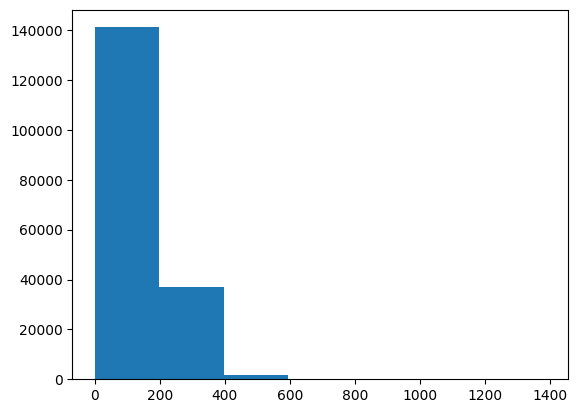

In [66]:
# Check the distribution of our sequences at a character_level

import matplotlib.pyplot as plt
plt.hist(char_lens, bins = 7);

In [67]:
# Find what character length covers 95% of sequences

output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [68]:
# Get all keyboard characters

import string
alphabet =string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [69]:
# Create char_levele token vectorizer instance

NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, ['UNK'])
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    #standardize = None, # set standardization to none if you want to leave punctuation in
                                    name = "char_vectorizer")

In [70]:
# Adapt character vectorizer to training character

char_vectorizer.adapt(train_chars)

In [71]:
# Check character vocab stats

char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [72]:
# Test our character vectorizer

random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars)}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized Chars:\n{vectorized_chars}")
print(f"Length of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
m i d l i f e   v i t a m i n   d   i n t a k e   e x h i b i t e d   a   c r o s s - t i m e   a n d   d o m a i n - s p e c i f i c   a s s o c i a t i o n   w i t h   c o g n i t i o n   i n   t h e   c o n t e x t   o f   a g i n g   .
Length of random_train_chars: 239
Vectorized Chars:
[[15  4 10 12  4 17  2 21  4  3  5 15  4  6 10  4  6  3  5 23  2  2 24 13
   4 22  4  3  2 10  5 11  8  7  9  9  3  4 15  2  5  6 10 10  7 15  5  4
   6  9 14  2 11  4 17  4 11  5  9  9  7 11  4  5  3  4  7  6 20  4  3 13
  11  7 18  6  4  3  4  7  6  4  6  3 13  2 11  7  6  3  2 24  3  7 17  5
  18  4  6 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0 

## Creating a character-level embedding

In [73]:
# Create char embedding layer

char_embed = layers.Embedding(input_dim = len(char_vocab), # number of different characters
                              output_dim = 25,
                              mask_zero = True,
                              name="char_embed")


In [74]:
# Test our character embedding layer

print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 m i d l i f e   v i t a m i n   d   i n t a k e   e x h i b i t e d   a   c r o s s - t i m e   a n d   d o m a i n - s p e c i f i c   a s s o c i a t i o n   w i t h   c o g n i t i o n   i n   t h e   c o n t e x t   o f   a g i n g   .

Embedded chars. (after vectorization and embedding):
[[[-0.03007985 -0.03390062 -0.01334979 ...  0.03119883  0.01131705
   -0.00161687]
  [-0.00556497 -0.03782929  0.00928926 ... -0.04948501 -0.04870854
    0.02967531]
  [-0.02577139 -0.04770683  0.04463008 ...  0.03424818  0.00740112
   -0.03931785]
  ...
  [ 0.00666314  0.01181016  0.02445899 ...  0.00232843 -0.0048326
   -0.04177942]
  [ 0.00666314  0.01181016  0.02445899 ...  0.00232843 -0.0048326
   -0.04177942]
  [ 0.00666314  0.01181016  0.02445899 ...  0.00232843 -0.0048326
   -0.04177942]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [75]:
# Make Conv1D on chars only

inputs = layers.Input(shape =(1,), dtype = "string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding = "same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs = outputs,
                         name = "model_3_conv1d_char_embeddings")

# Compile the model
model_3.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [76]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

In [77]:
# Create char level datasets

train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((tests_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [78]:
# Fit the model on chars only

model_3_history = model_3.fit(train_char_dataset,
                              epochs= 3,
                              steps_per_epoch =int(0.1*len(train_char_dataset)),
                              validation_data = val_char_dataset,
                              validation_steps = (0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 16s 26ms/step - loss: 1.2925 - accuracy: 0.4722 - val_loss: 1.0734 - val_accuracy: 0.5763
Epoch 2/3
562/562 [==============================] - 14s 26ms/step - loss: 1.0221 - accuracy: 0.5923 - val_loss: 0.9609 - val_accuracy: 0.6207
Epoch 3/3
562/562 [==============================] - 14s 26ms/step - loss: 0.9343 - accuracy: 0.6324 - val_loss: 0.8756 - val_accuracy: 0.6553


In [79]:
# Make predictions with character model only

model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 8s 8ms/step


array([[0.18699808, 0.27947745, 0.14025472, 0.29949516, 0.09377455],
       [0.20818415, 0.5668587 , 0.01254703, 0.13454658, 0.07786347],
       [0.1017591 , 0.52490985, 0.17985305, 0.13360626, 0.05987182],
       ...,
       [0.01335313, 0.01775506, 0.13008109, 0.02259874, 0.816212  ],
       [0.03637969, 0.07611859, 0.4965254 , 0.07588466, 0.31509173],
       [0.37940025, 0.39715946, 0.12056907, 0.09542788, 0.00744339]],
      dtype=float32)

In [80]:
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 1, ..., 4, 2, 1])>

In [81]:
# Calculate results for Conv1D model chars only

model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_preds)
model_3_results

{'accuracy': 65.17939891433868,
 'precision': 0.6481814871191476,
 'recall': 0.6517939891433867,
 'f1': 0.6401678813506914}

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level moodel (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output


In [82]:
# 1. Setup token inputs/model

token_inputs = layers.Input(shape=[], dtype = tf.string, name = "token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model

char_inputs = layers.Input(shape=(1,), dtype = tf.string, name = "char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_ltsm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_ltsm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybird")([token_model.output,
                                                                  char_model.output])


# 4. Create output layers - adding in Dropout

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = "relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation = "softmax")(final_dropout)

# 5. Construct model with char and token inputs

model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer,
                         name = "model_4_token_and_char_embeddings")

In [83]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

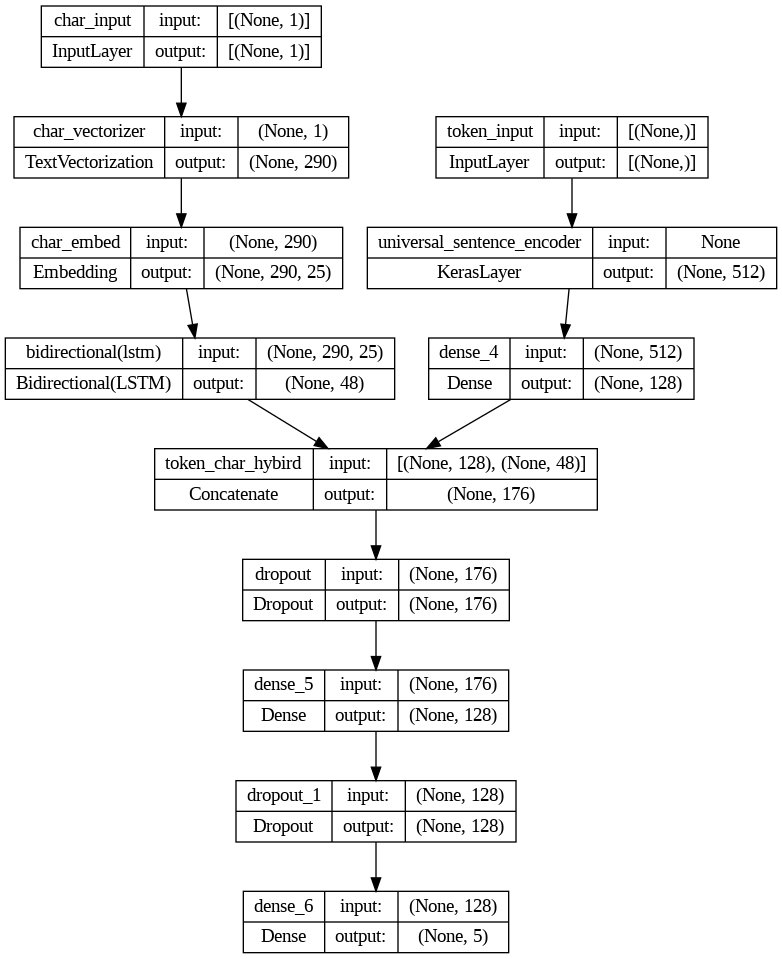

In [84]:
# Plot hybrid token and character model

from keras.utils import plot_model
plot_model(model_4, show_shapes = True)

In [85]:
# Compile token char model

model_4.compile(loss= "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics =["accuracy"])

### Combining token and character data into  a tf.data Dataset

In [86]:
# Combine chars and tokens into a dataset

train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [87]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [88]:
# Check out our training char and token embedding dataset

train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level-sequences


In [89]:
# Fit the model on tokens and chars

history_model_4 =model_4.fit(train_char_token_dataset,
                             steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                             epochs = 3,
                             validation_data = val_char_token_dataset,
                             validation_steps = int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 217s 367ms/step - loss: 0.9789 - accuracy: 0.6123 - val_loss: 0.7733 - val_accuracy: 0.7041
Epoch 2/3
562/562 [==============================] - 197s 350ms/step - loss: 0.8017 - accuracy: 0.6912 - val_loss: 0.7199 - val_accuracy: 0.7264
Epoch 3/3
562/562 [==============================] - 206s 366ms/step - loss: 0.7748 - accuracy: 0.7017 - val_loss: 0.6900 - val_accuracy: 0.7377


In [90]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 72s 77ms/step - loss: 0.6937 - accuracy: 0.7362


[0.6937465071678162, 0.7361975312232971]

In [91]:
# Make predictions using the token-character model hybird

model_4_pred_probs = model_4.predict(val_char_token_dataset)

945/945 [==============================] - 77s 78ms/step


In [92]:
model_4_pred_probs

array([[4.8036048e-01, 2.6387507e-01, 4.1132062e-03, 2.4749973e-01,
        4.1515073e-03],
       [3.3143741e-01, 5.4937994e-01, 3.7436921e-03, 1.1342241e-01,
        2.0165457e-03],
       [2.9522124e-01, 3.2696685e-01, 4.4401687e-02, 2.9593167e-01,
        3.7478551e-02],
       ...,
       [6.0050783e-04, 7.3049152e-03, 5.3448871e-02, 1.5659702e-04,
        9.3848914e-01],
       [8.6755501e-03, 5.0623503e-02, 2.5071394e-01, 4.3420936e-03,
        6.8564487e-01],
       [3.9602819e-01, 3.0205646e-01, 2.4056610e-01, 2.9155435e-02,
        3.2193821e-02]], dtype=float32)

In [93]:
# Format pred probs into pred labels

model_4_preds = tf.argmax(model_4_pred_probs, axis =1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 1, ..., 4, 4, 0])>

In [94]:
# Get results of token-char-hybird model

model_4_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.61975374023567,
 'precision': 0.7392993698857541,
 'recall': 0.7361975374023567,
 'f1': 0.7346017894417805}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

### Create positional embeddings

In [95]:
# How many different line numbers are there ?

train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

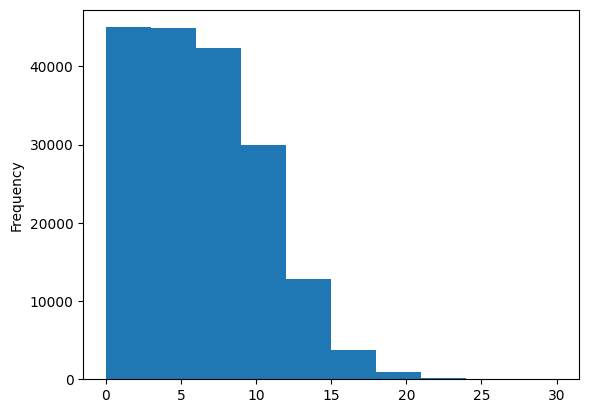

In [96]:
# Check the distribution of "line number" column

train_df.line_number.plot.hist()

In [97]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column

train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth = 15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

Now we've encoded our line numbers feature, let's do the same for our total lines feature...

In [98]:
# How many different numbers of lines are there?

train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

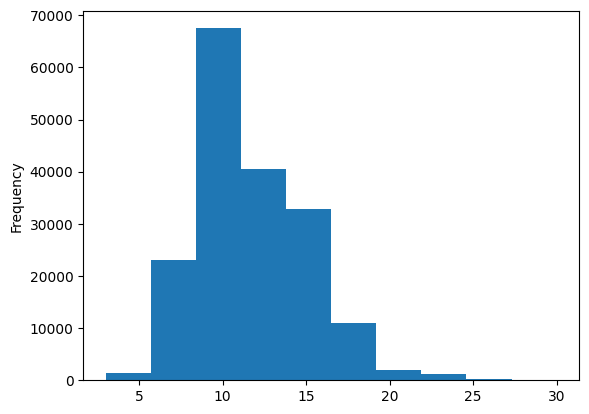

In [99]:
# Check the distributions of total lines

train_df.total_lines.plot.hist();

In [100]:
# Check the coverage of a "total_lines" value of 20


np.percentile(train_df.total_lines, 98)

20.0

In [101]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature


train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth =20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth =20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth =20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a tribrid embedding model


1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribried embedding and output label probabilities
8. Combine the inputs 1, 2, 3, 4, and outputs of into a tf.keras.Model

In [102]:
# 1. Token inputs

token_inputs = layers.Input(shape=[], dtype = "string", name = "token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)

# 2. Char inputs

char_inputs = layers.Input(shape = (1, ), dtype= "string", name = "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Line numbers model
# inputs, shape = ?
line_number_inputs = layers.Input(shape = (15,), dtype = tf.float32, name = "line_number_input")
# dense layer with 32 units & relu activation
x = layers.Dense(32, activation = "relu")(line_number_inputs)
# combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs = x)

# 4. Total lines model

total_lines_inputs = layers.Input(shape = (20,), dtype = tf.float32, name = "total_lines_input")
y = layers.Dense(32, activation = "relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs = total_lines_inputs,
                                  outputs = y)

# 5. Combine token and char embeddings into a hybird embedding

combined_embeddings = layers.Concatenate(name = "char_token_hybird_embedding")([token_model.output,
                                                                                char_model.output])
z = layers.Dense(256, activation = "relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)
# 6. Combine positional embedding with combined token and char embeddings

tribrid_embeddings = layers.Concatenate(name = "char_token_positional_embedding")([line_number_model.output,
                                                                                   total_line_model.output,
                                                                                  z])

# 7. Create output layer

output_layer = layers.Dense(num_classes, activation = "softmax", name = "output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs

model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_line_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer,
                         name = "model_5_tribrid_embeddings")

In [103]:
# Get a summary of our ribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_

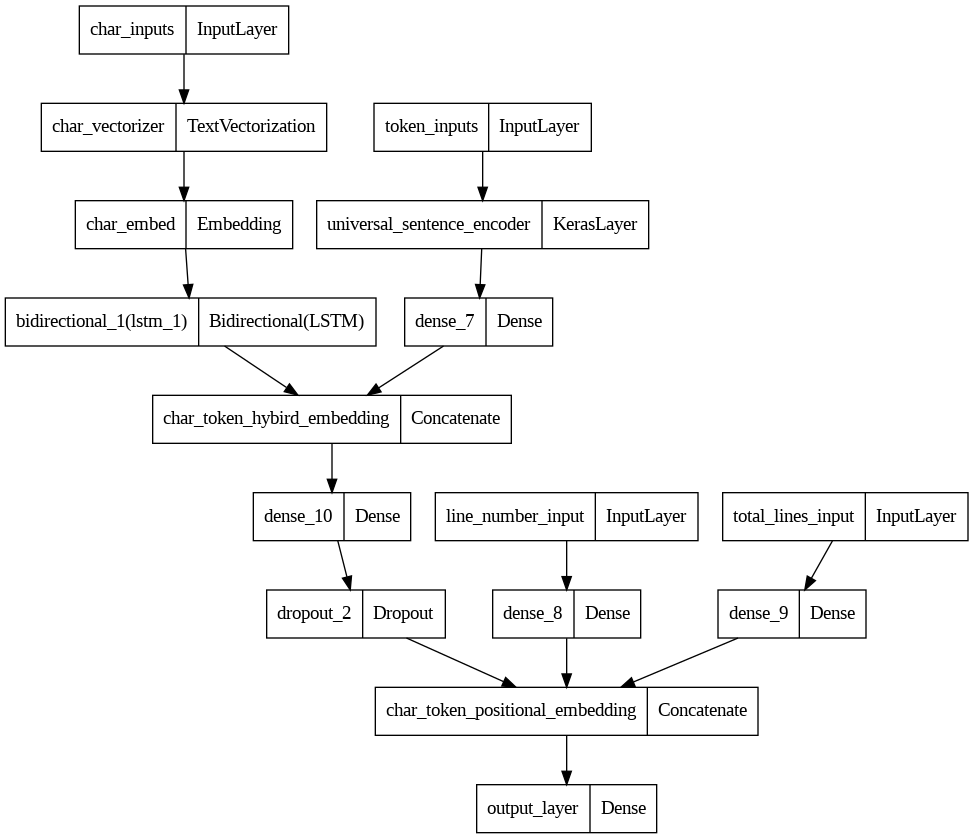

In [104]:
# Plot model_5 to explore it visually...

from tensorflow.keras.utils import plot_model

plot_model(model_5)

In [105]:
# Compile token, char, and positional embedding model

model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

### Create tribrid embedding datasets using tf.data

In [106]:


# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predicitions with our tribrid model

In [107]:
# Fit our tribrid embedding model

history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch = int(0.1 * len(train_pos_char_token_dataset)),
                              epochs = 3,
                              validation_data = val_pos_char_token_dataset,
                              validation_steps = int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 218s 368ms/step - loss: 1.0973 - accuracy: 0.7255 - val_loss: 0.9824 - val_accuracy: 0.8029
Epoch 2/3
562/562 [==============================] - 205s 364ms/step - loss: 0.9672 - accuracy: 0.8174 - val_loss: 0.9475 - val_accuracy: 0.8288
Epoch 3/3
562/562 [==============================] - 204s 364ms/step - loss: 0.9491 - accuracy: 0.8249 - val_loss: 0.9381 - val_accuracy: 0.8301


In [108]:
# Make predictions with the car token pos model

model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose = 1)
model_5_pred_probs

945/945 [==============================] - 76s 77ms/step


array([[0.5018633 , 0.10961149, 0.01279915, 0.35656714, 0.01915894],
       [0.56463885, 0.09520423, 0.0450247 , 0.28417432, 0.01095774],
       [0.29554316, 0.09979004, 0.124125  , 0.4054406 , 0.0751012 ],
       ...,
       [0.03198174, 0.09669384, 0.04600985, 0.03092215, 0.7943924 ],
       [0.03458824, 0.24992494, 0.06170769, 0.02963584, 0.6241433 ],
       [0.19186859, 0.6003672 , 0.10316138, 0.04359967, 0.06100305]],
      dtype=float32)

In [109]:
# Convert pred probs to pred labels

model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)

model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [111]:
# Calculate results of char token pos model


model_5_results = calculate_results(y_true = val_labels_encoded,
                                       y_pred = model_5_preds)

In [112]:
model_5_results

{'accuracy': 83.39070567986231,
 'precision': 0.8326019088241401,
 'recall': 0.8339070567986231,
 'f1': 0.8329284281273236}

### Compare model results

In [113]:
# Combine model results into a dataframe

all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                 "model_1_custom_token_embedding": model_1_results,
                                 "model_2_pretrained_token_embedding":model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.210645,0.778981,0.782106,0.779449
model_2_pretrained_token_embedding,71.282934,0.713635,0.712829,0.709743
model_3_custom_char_embedding,65.179399,0.648181,0.651794,0.640168
model_4_hybrid_char_token_embedding,73.619754,0.739299,0.736198,0.734602
model_5_pos_char_token_embedding,83.390706,0.832602,0.833907,0.832928


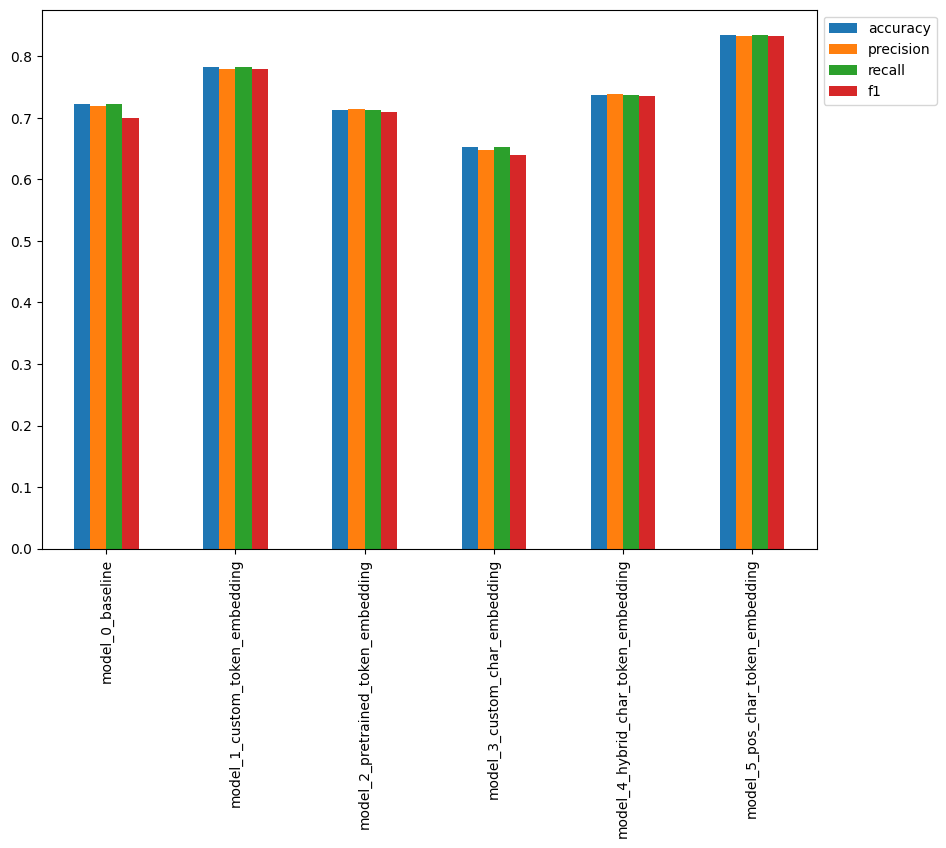

In [114]:
# Reduce the accuracy to same scale as other metrics

all_model_results["accuracy"] = all_model_results["accuracy"]/100

# Plot and compare all model results

all_model_results.plot(kind="bar", figsize = (10,7)).legend(bbox_to_anchor=(1.0,1.0))

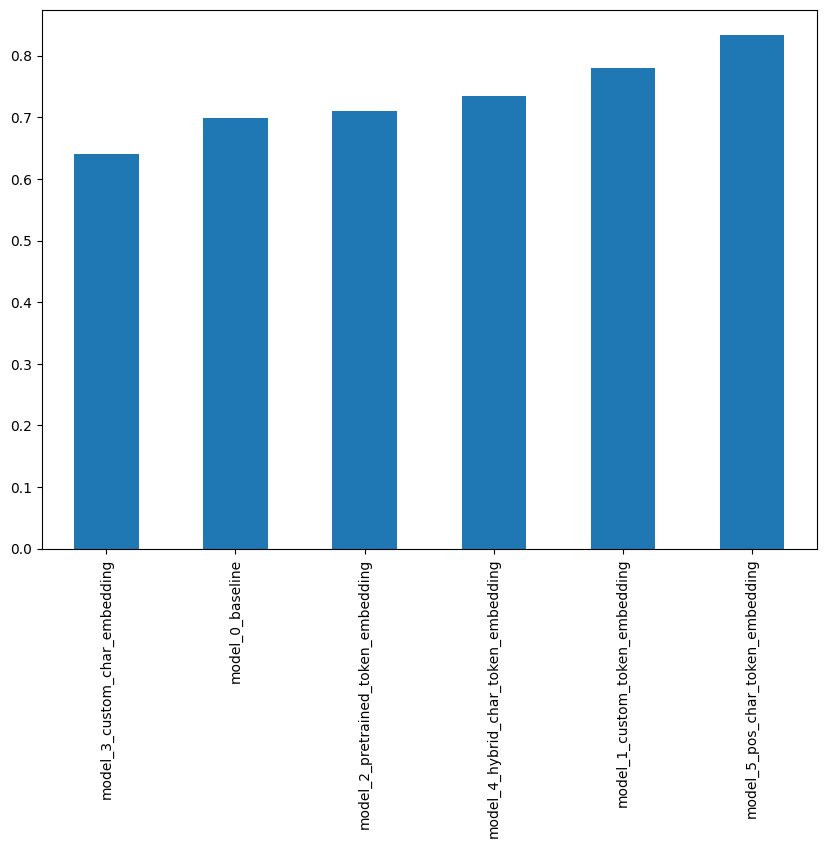

In [115]:
# Sort models results by f1-score


all_model_results.sort_values("f1", ascending = True)["f1"].plot(kind="bar", figsize=(10,7));

## Save and load model

In [116]:
# Save the best performing model to SavedModel format (default)

model_5.save("skimlit_tribrid_model")

In [117]:
# Load in best performing model

loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")